In [ ]:
!pip install bert-score

In [ ]:
!python -m unittest discover

In [ ]:
import bert_score
bert_score.__version__

'0.3.11'

In [ ]:
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["xtick.major.size"] = 0
rcParams["xtick.minor.size"] = 0
rcParams["ytick.major.size"] = 0
rcParams["ytick.minor.size"] = 0

rcParams["axes.labelsize"] = "large"
rcParams["axes.axisbelow"] = True
rcParams["axes.grid"] = True

**Load WMT15 data**

In [ ]:
with open("/content/mt.txt") as f:
    hyp_snts = [line[:-1] for line in f] # remove last symbol which is '\n'

with open("/content/reference.txt") as f:
    ref_snts = [line[:-1] for line in f]

with open("/content/newstest2015.human.de-en") as f:
    human_scores = [float(line[:-1]) for line in f] 

**Load WMT21 data**


In [ ]:
# import pickle
# with open('/content/all_ref_snts_21.pickle', 'rb') as fp:
#     ref_snts = pickle.load(fp)

# with open('/content/all_mt_snts_21.pickle', 'rb') as fp:
#     hyp_snts = pickle.load(fp)

# with open('/content/all_z_mqm_scores.pickle', 'rb') as fp:
#     human_scores = pickle.load(fp)

# with open('/content/all_src_snts_21.pickle', 'rb') as fp:
#     src_snts = pickle.load(fp)

In [ ]:
# Check the model architecture

# from transformers import BertModel
# model = BertModel.from_pretrained('xlm-roberta-large')
# model

**Run BERTScore and compute correlation**

In [ ]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from bert_score import score
from bert_score import plot_example

In [ ]:
metric_scores = pd.DataFrame({"human": human_scores}) 

In [ ]:
# Set up parameters

wmt_data = "wmt15"
type_of_processing = 'tokenize_and_lower'
lang = 'en'
use_idf = False
rescale = True

In [ ]:
# use multilingual model for german
if lang == 'en':
    model_name = 'microsoft/deberta-xlarge-mnli'  # | 'facebook/bart-large-mnli'
else:
    model_name = 'xlm-roberta-large' # | 'bert-base-multilingual-cased'

bert_scores = {}
P, R, F1 = score(hyp_snts, ref_snts, lang=lang, idf=use_idf,  verbose=True, model_type=model_name, rescale_with_baseline=rescale, batch_size=128) 

pref = model_name.split('/')[-1]
bert_scores[f"bert_{pref}_{type_of_processing}_P"] = P.numpy().tolist()
bert_scores[f"bert_{pref}_{type_of_processing}_R"] = R.numpy().tolist()
bert_scores[f"bert_{pref}_{type_of_processing}_F1"] = F1.numpy().tolist()

In [ ]:
for st in bert_scores:
    metric_scores[st] = bert_scores[st]

In [ ]:
metric_scores.corr()

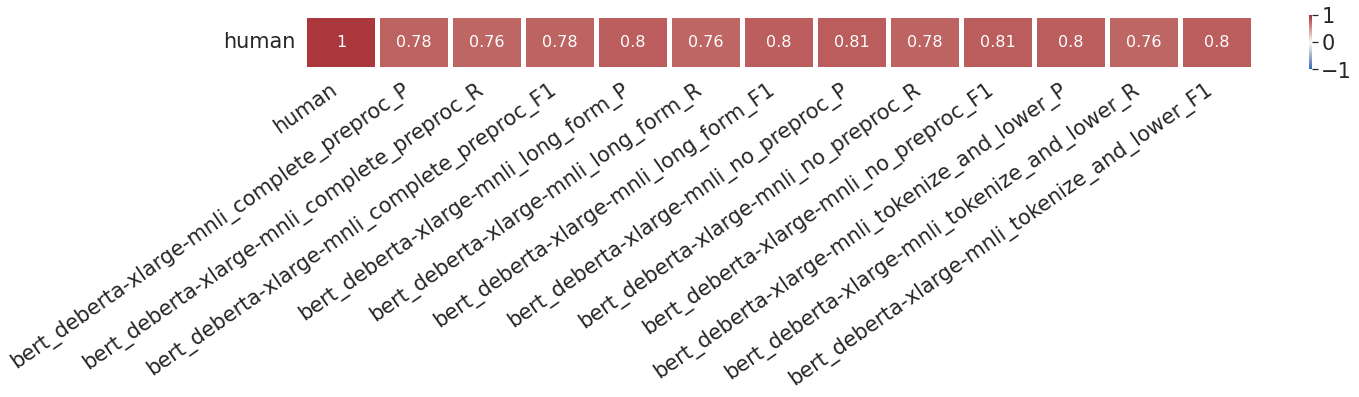

In [ ]:
sns.set(rc={'figure.figsize':(20, 1)})
sns.set(font_scale=1.9)

m = metric_scores.corr().round(2)[:1]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 16},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=35, horizontalalignment='right')
fig.set_yticklabels(fig.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

In [ ]:
file_name = 'bert_scores_dict_'
if use_idf:
    file_name += 'ifd_'
if rescale:
    file_name += 'rescaled_'
file_name = file_name + type_of_processing + f'_{wmt_data}.pickle'

with open(file_name, 'wb') as f:
    pickle.dump(bert_scores, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

In [ ]:
plt.hist(R, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

In [ ]:
plt.hist(P, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

In [ ]:
single_cands = ['I like lemons.']
multi_refs = [['I am proud of you.', 'I love lemons.', 'Go go go.']]

P_mul, R_mul, F_mul = score(single_cands, multi_refs, lang="en", rescale_with_baseline=True)
print(P_mul, R_mul, F_mul)

In [ ]:
plot_example(hyp_snts[0], ref_snts[0], lang="en")

In [ ]:
# Example from RegEMT paper to show that BERTScore is sensitive to such type of adversarial examples

ref = "I never wrote this article, I just edited it."
hyp1 = "It is not my article, I just edited it."
hyp2 = "I never wrote this article, I never edited it."

# P, R, F = score([hyp1, hyp2], [ref, ref], lang=lang, rescale_with_baseline=rescale)

print(f'Reference:\t{ref}')
print(f'Hypothesis 1:\t{hyp1}')
print(f'Hypothesis 2:\t{hyp2}\n')
print(f'BERTScore for hyp1:\tprec={round(P[0].item(), 4)}, rec={round(R[0].item(), 4)}, F1={round(F[0].item(), 4)}')
print(f'BERTScore for hyp2:\tprec={round(P[1].item(), 4)}, rec={round(R[1].item(), 4)}, F1={round(F[1].item(), 4)}')

Reference:	I never wrote this article, I just edited it.
Hypothesis 1:	It is not my article, I just edited it.
Hypothesis 2:	I never wrote this article, I never edited it.

BERTScore for hyp1:	prec=0.7319, rec=0.755, F1=0.7438
BERTScore for hyp2:	prec=0.8892, rec=0.8322, F1=0.8608
